In [1]:
import skimage.io as io
import skimage as sk
from skimage.color import rgb2gray
from skimage.transform import resize
import time
import numpy as np
import os
import copy
from tqdm.auto import tqdm

from unitTesting import UnitTest
import adaboost.adaboost as ab
import utilitis as ut

c:\Users\Ahmed Ismail\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Unit Testing

In [2]:
# img = io.imread('./test.jpg')
# img = rgb2gray(img)
# unitTesting = UnitTest(img)

# Getting Datasets

In [3]:


#load positive dataset
try:
    print("Loading positive dataset...")
    positiveDataset = np.load("./Dataset/posTrain2.npy")
except:
    print("No dataset found, creating new dataset...")
    # positiveDataset = np.load("./Dataset/olivetti_faces.npy")
    positiveDataset = np.load("./testImg/postTrain.npy")
    personID = np.load("./Dataset/olivetti_faces_target.npy")


    #resize images to 24x24
    newPositiveDataset = np.empty(shape=(positiveDataset.shape[0], 24, 24))
    for i in range(len(positiveDataset)):
        newImg = np.array(positiveDataset[i])
        
        finalImg = resize(newImg, (24, 24))
        newPositiveDataset[i] = finalImg

    positiveDataset = newPositiveDataset

    # for i in range(10):
    #     io.imshow(positiveDataset[i])
    #     io.show()

    # print(positiveDataset.shape)

    

    # np.save("./Dataset/positiveDataset.npy", positiveDataset)
    # print("Positive Dataset saved")

#loading negative dataset
try:
    print("Loading negative dataset...")
    negativeDataset = np.load("./Dataset/negTrain.npy")
except:
    print("No dataset found, creating new dataset...")
    directory = "./Dataset/NegativeSet"
    negativeDataset = np.empty(shape=(len(os.listdir(directory)), 24, 24))
    i = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            curImg = io.imread(os.path.join(directory, filename), as_gray=True)
            newImg = resize(curImg, (24, 24))
            negativeDataset[i] = newImg
            i += 1
    # negativeDataset = negativeDataset.reshape(len(os.listdir(directory)), 64, 64)
    # print(negativeDataset.shape)
    # np.save("./Dataset/negativeDataset.npy", negativeDataset)
    # print("Negative Dataset saved")



posDataset, negDataset = ut.preprocessImages(positiveDataset, negativeDataset)

print(f"Positive Dataset Shape: {posDataset.shape}")
print(f"Negative Dataset Shape: {negDataset.shape}")



Loading positive dataset...
Loading negative dataset...
Positive Dataset Shape: (834, 24, 24)
Negative Dataset Shape: (357, 24, 24)


# Training

In [4]:
minFeatureWidth = 4
maxFeatureWidth = 20
minFeatureHeight = 4
maxFeatureHeight = 20
nClassifiers = 5001
threshold = 0

classifiersToBeUsed = []
try :
    print("Loading classifiers...")
    classifiersToBeUsed = np.load("./Classifiers/classifiers5001-0-4-20.npy", allow_pickle=True)
except Exception as e:
    # print(e)
    print("No classifiers found, creating new classifiers...")
    classifier = ab.AdaBoost()
    start = time.time()
    classifiersToBeUsed = classifier.learn(posDataset, negDataset,threshold,minFeatureWidth,minFeatureHeight,maxFeatureWidth,maxFeatureHeight, nClassifiers)
    end = time.time()
    classifiersToBeUsed = np.array(classifiersToBeUsed)
    np.save("./classifiers"+str(nClassifiers)+"-" + str(threshold)+ "-"+str(minFeatureWidth)+"-" + str(maxFeatureWidth)+ ".npy", classifiersToBeUsed)
    print("Time taken to train the classifier: ", end-start)

print("Classifiers loaded successfully")








Loading classifiers...
No classifiers found, creating new classifiers...
Calculating integral images...
Done!

Creating initial weights and labels...
Done!

Calculating all possible haar features...
Total number of features = 164832
Done!

Calculating votes of all haar features for all samples...


KeyboardInterrupt: 

In [ ]:
# start = time.time()
# trainFaces = np.load("./TestImg/realFaces.npy")
# classifier = ab.AdaBoost()
# trainedClassifiersToBeUsed = classifier.train(trainFaces, negDataset, nClassifiers,classifiersToBeUsed)
# end = time.time()

# Testing

In [ ]:
testDataSet = np.load("./Dataset/testMix.npy")
testDataSetTarget = np.load("./Dataset/testTargets.npy")
#convert to int 
testDataSetTarget = testDataSetTarget.astype(int)

print(f"Test Dataset Shape: {testDataSet.shape}")

#get integral images
ii = np.array([ut.integralImage(test) for test in testDataSet])

i = 0
correctCount = 0
firstWrong = 5
facesCount = 0
correctFacesCount = 0
correctNonFacesCount = 0
nonFacesCount = 0
for test in ii:
    predicted = ut.getVotes(np.array(classifiersToBeUsed), test)
    if predicted == testDataSetTarget[i]:
        correctCount += 1
        if predicted == 1:
            correctFacesCount += 1
        else:
            correctNonFacesCount += 1
    else:
        if firstWrong > 0:
            print("Predicted: ", predicted)
            print("Target: ", testDataSetTarget[i])
            # io.imshow(testDataSet[i])
            # io.show()
            firstWrong -= 1
    if testDataSetTarget[i] == 1:
        facesCount += 1
    if testDataSetTarget[i] == 0:
        nonFacesCount += 1
    
    i += 1

print("Accuracy: ", correctCount/len(testDataSet) * 100, "%")
print(f"Faces detected: {correctFacesCount} / {facesCount} , Accuracy: {correctFacesCount/facesCount * 100}%")
print(f"Non Faces detected: {correctNonFacesCount} / {nonFacesCount} , Accuracy: {correctNonFacesCount/nonFacesCount * 100}%")

Test Dataset Shape: (160, 24, 24)
Predicted:  0
Target:  1
Predicted:  0
Target:  1
Predicted:  0
Target:  1
Accuracy:  98.125 %
Faces detected: 97 / 100 , Accuracy: 97.0%
Non Faces detected: 60 / 60 , Accuracy: 100.0%


# Actual Run

In [ ]:
def scaleFeatures(features, scale):

    
    features2 = copy.deepcopy(features)
    try:
        finalFeatures = np.load("./ScaledFeatures/scaledFeatures"+str(scale)+ ".npy", allow_pickle=True)
        print(f"Features with scale {scale} loaded successfully")
        return np.array(finalFeatures)
    except:
        print("No features found, creating new features...")

        finalFeatures = []
        for f in features2:
            if f.x + f.width > 24:
                print(f"x + width > 24, x: {f.x}, width: {f.width}")

            if f.y + f.height > 24:
                print(f"y + height > 24 , y: {f.y}, height: {f.height}")

            f = f * float(scale)
            finalFeatures.append(f)
        finalFeatures2 = np.array(finalFeatures)
        np.save("./scaledFeatures"+str(scale) + ".npy", finalFeatures2)
        print("Features saved successfully")
        return finalFeatures2


In [ ]:
def predict(img2, classifiersToBeUsedFn) -> list:
    img = np.copy(img2)
    img = rgb2gray(img)
    img = img/img.max()
    img = img / np.var(img)


    ii = ut.integralImage(img)
    imgHeight, imgWidth = img.shape

    if imgHeight < 24 or imgWidth < 24:
        return []

    #scaling features
    maxScaleFactor = min(imgHeight/24, imgWidth/24)


    
    detectedFaces = []



    print("Scaling features...")
    scaledFeatures2_5 = scaleFeatures(classifiersToBeUsedFn, 2.5)
    scaledFeatures2_5 = scaledFeatures2_5.squeeze()

    scaledFeatures3_75 = scaleFeatures(classifiersToBeUsedFn, 3.75)
    scaledFeatures3_75 = scaledFeatures3_75.squeeze()

    scaledFeatures5 = scaleFeatures(classifiersToBeUsedFn, 5)
    scaledFeatures5 = scaledFeatures5.squeeze()

    scaledFeatures6_25 = scaleFeatures(classifiersToBeUsedFn, 6.25)
    scaledFeatures6_25 = scaledFeatures6_25.squeeze()

    scaledFeatures7_5 = scaleFeatures(classifiersToBeUsedFn, 7.5)
    scaledFeatures7_5 = scaledFeatures7_5.squeeze()

    scaledFeatures8_75 = scaleFeatures(classifiersToBeUsedFn, 8.75)
    scaledFeatures8_75 = scaledFeatures8_75.squeeze()

    scaledFeatures10 = scaleFeatures(classifiersToBeUsedFn, 10)
    scaledFeatures10 = scaledFeatures10.squeeze()

    scaledFeatures11_25 = scaleFeatures(classifiersToBeUsedFn, 11.25)
    scaledFeatures11_25 = scaledFeatures11_25.squeeze()

    scaledFeatures12_5 = scaleFeatures(classifiersToBeUsedFn, 12.5)
    scaledFeatures12_5 = scaledFeatures12_5.squeeze()

    print("Features scaled successfully\n")
    scaledFeatures = [scaledFeatures2_5, scaledFeatures3_75, scaledFeatures5, scaledFeatures6_25, scaledFeatures7_5, scaledFeatures8_75, scaledFeatures10, scaledFeatures11_25, scaledFeatures12_5]


    #print the max x and y in classifiersToBeUsed
    # maxX = 0
    # maxY = 0
    # maxWidth = 0
    # maxHeight = 0
    # maxTotX = 0
    # maxTotY = 0
    # for f in scaledFeatures5 :
    #     if not isinstance(f.x, int):
    #         print("x is float")
    #     if not isinstance(f.y, int):
    #         print("y is float")
    #     if not isinstance(f.width, int):
    #         print("width is float")
    #     if not isinstance(f.height, int):
    #         print("height is float")

            
    #     if f.x + f.width > maxTotX:
    #         maxX = f.x
    #         maxWidth = f.width
    #         maxTotX = f.x + f.width
    #     if f.y + f.height > maxTotY:
    #         maxY = f.y
    #         maxHeight = f.height
    #         maxTotY = f.y + f.height
    # print(f"===========Max x: {maxX} and maxWidth = {maxWidth} with MaxTotX = {maxTotX} and max y: {maxY} and maxHeight = {maxHeight} with MaxTotY = {maxTotY}")
    # print(f"scale factor: {scaledFeatures5[0].scale} \n")
    
    

    # print(f"shape of scaled features: {scaledFeatures[0].shape}")
    shiftValue = 1
    for features in scaledFeatures:
        scaleFactor = features[0].scale
        print(f"Scale factor: {scaleFactor} and max scale factor: {maxScaleFactor}")
        if scaleFactor > maxScaleFactor:
            print("Scale factor greater than max scale factor, breaking")
            break
        print(f"\nRunning scale factor: {scaleFactor}")
        #print max x and y in features
        # maxX = 0
        # maxY = 0
        # for f in features:
        #     if f.x + f.width > maxX:
        #         maxX = f.x + f.width
        #     if f.y + f.height > maxY:
        #         maxY = f.y + f.height
        # print(f"maxX: {maxX}, maxY: {maxY}")
        # print(f"min x = {0} max x = {int(imgWidth - (24 * scaleFactor))} shift value = {int(np.round(shiftValue * scaleFactor))}")
        for x in tqdm(range(0, int(imgWidth - (24 * scaleFactor)), int(np.round(shiftValue * scaleFactor)))):
            scaledFeatures2 = copy.deepcopy(features)
            scaledFeatures2 = [sf + (x,0) for sf in scaledFeatures2]
            # maxX = 0
            # maxY = 0
            # for f in scaledFeatures2:
            #     if f.x + f.width > maxX:
            #         maxX = f.x + f.width
            #     if f.y + f.height > maxY:
            #         maxY = f.y + f.height
            # print(f"maxX: {maxX}, maxY: {maxY}")
            # print(f"min y = {0} max y = {int(imgHeight - (24 * scaleFactor))} shift value = {int(np.round(shiftValue * scaleFactor))}")
            for y in range(0, int(imgHeight - (24 * scaleFactor)), int(np.round(shiftValue * scaleFactor))):
                # print(f"scale factor: {scaleFactor}, x: {x}, y: {y}")
                if ut.getVotes(scaledFeatures2, ii) == 1:
                    detectedFaces.append([x, y, scaleFactor])
                scaledFeatures2 = [sf + (0,int(np.round(shiftValue * scaleFactor))) for sf in scaledFeatures2]
        print("Finished scale factor: ", scaleFactor)
    
    return detectedFaces




In [ ]:
def drawRect(img2, x, y, scaleFactor):
    img = np.copy(img2)
    img = img/img.max()
    if len(img.shape) == 3:
        img = rgb2gray(img)
    # print(img.shape)
    imgHeight, imgWidth = img.shape
    x = int(x)
    y = int(y)
    scaleFactor = int(scaleFactor)
    for i in range(x, x + (24 * scaleFactor)):
        if i < imgWidth and y < imgHeight:
            img[y][i] = 1
        if i < imgWidth and y + (24 * scaleFactor) < imgHeight:
            img[y + (24 * scaleFactor)][i] = 1
    for i in range(y, y + (24 * scaleFactor)):
        if i < imgHeight and x < imgWidth:
            img[i][x] = 1
        if i < imgHeight and x + (24 * scaleFactor) < imgWidth:
            img[i][x + (24 * scaleFactor)] = 1
    return img





Scaling features...
Features with scale 2.5 loaded successfully
Features with scale 3.75 loaded successfully
Features with scale 5 loaded successfully
Features with scale 6.25 loaded successfully
Features with scale 7.5 loaded successfully
Features with scale 8.75 loaded successfully
Features with scale 10 loaded successfully
Features with scale 11.25 loaded successfully
Features with scale 12.5 loaded successfully
Features scaled successfully

Scale factor: 2.5 and max scale factor: 6.25

Running scale factor: 2.5


100%|██████████| 45/45 [02:21<00:00,  3.15s/it]


Finished scale factor:  2.5
Scale factor: 3.75 and max scale factor: 6.25

Running scale factor: 3.75


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Finished scale factor:  3.75
Scale factor: 5.0 and max scale factor: 6.25

Running scale factor: 5.0


100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


Finished scale factor:  5.0
Scale factor: 6.25 and max scale factor: 6.25

Running scale factor: 6.25


0it [00:00, ?it/s]


Finished scale factor:  6.25
Scale factor: 7.5 and max scale factor: 6.25
Scale factor greater than max scale factor, breaking
================No faces detected================


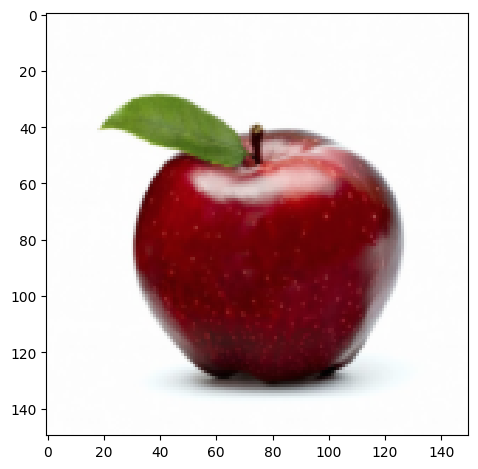

In [ ]:
def detectFaces(img, classifiersToBeUsedFn, threshold = 0):
    if img.shape[0] > 150 or img.shape[1] > 150:
        img = resize(img, (150, 150))
    detectedFaces = predict(img, classifiersToBeUsedFn)

    if len(detectedFaces) > threshold:
        print(f"==========Face detected==============")
        io.imshow(img)
        io.show()
        return img
    else:
        print("================No faces detected================")
        io.imshow(img)
        io.show()
        return None

threshold = 30
# img = io.imread("./TestImg/Lopez.jpg")
# detectedFace = detectFaces(img, classifiersToBeUsed,threshold)

img = io.imread("./TestImg/ultimate.jpg")
detectedFace = detectFaces(img, classifiersToBeUsed,threshold)


